In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
                                                  
from general_tools.in_out.basics import create_dir, files_in_subdirs

from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, convolutional_discriminator,\
                                                          point_cloud_generator, leaky_relu, mlp_discriminator

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
save_model = True
save_synthetic_samples = True
class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'

do_training = True
do_plotting = True
n_pc_samples = 2048

max_epochs = 1500
arch_tag = 'mlp_arch'
leak = 0.2
dropout_prob = 0.5

discriminator = mlp_discriminator
adaptive_training = None

beta = 0.5
disc_kwargs = {'non_linearity': leaky_relu(leak), 'dropout_prob': dropout_prob}
    
generator = point_cloud_generator
gen_kwargs = {'b_norm': False, 'layer_sizes':[64, 128, 256, 512, 1024], 'dropout_prob':dropout_prob}
experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,
                                                                           n_threads=25, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [6]:
training_data = PointCloudDataSet(full_pclouds)
# training_data = PointCloudDataSet(full_pclouds[:100])

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = 512
init_lr = 0.0001

n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [7]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_samples, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (1.3758649914352983, 0.70542184291062526) 41.6453630924
2 (1.3579174942440457, 0.72290689503705063) 41.0534100533
3 (1.2747240410910712, 0.83237682625099463) 41.2897641659
4 (1.3459726015726725, 0.78737216967123524) 41.2314388752
5 (1.3582193904452853, 0.72633684785277752) 41.2315950394
6 (1.3420796438499734, 0.74138115114635894) 41.206594944
7 (1.3250532768390797, 0.78079077402750652) 41.2160840034
8 (1.2912870574880528, 0.81091671343202942) 41.2466309071
9 (1.2807721164491441, 0.81183823921062326) 41.1990160942
10 (1.2670852652302496, 0.83775317713066388) 41.3898279667
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/raw_gan/chair_mlp_arch_raw_gan_2048_pts/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


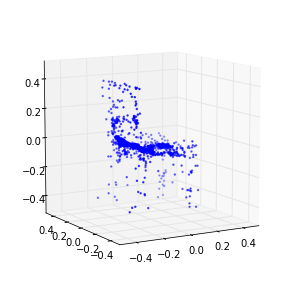

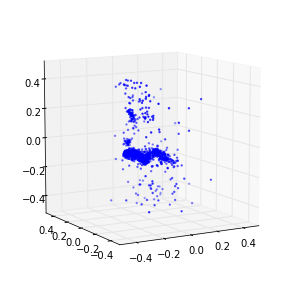

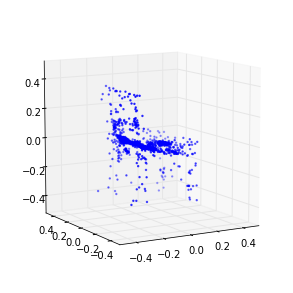

11 (1.2408060162155716, 0.87217599330125029) 41.30210495
12 (1.2227465859165898, 0.89173894546650079) 41.4803380966
13 (1.2134374088711208, 0.89578456657904171) 41.4492180347
14 (1.1957643817972254, 0.90353612149203266) 41.4594640732
15 (1.2364110266720807, 0.87625504798359344) 41.4124419689
16 (1.2382881217532689, 0.87291619512769913) 41.4173748493
17 (1.2609513300436515, 0.85494033407281944) 41.4080488682
18 (1.2671123919663605, 0.86791054849271421) 41.4681661129
19 (1.2622333076265124, 0.86431407597329879) 41.4296870232
20 (1.2486639296566999, 0.8607138333497224) 41.4608249664
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/raw_gan/chair_mlp_arch_raw_gan_2048_pts/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


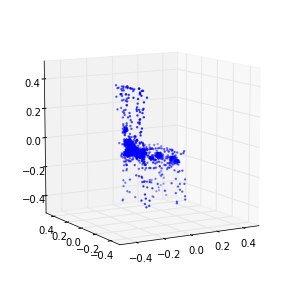

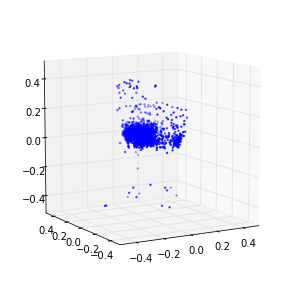

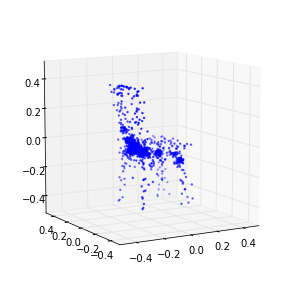

21 (1.2406880449365687, 0.87088947472748934) 41.3744080067
22 (1.2467426035139295, 0.86904261355046875) 41.2807769775
23 (1.2455482959747315, 0.86633584742192871) 41.3536410332
24 (1.2680683462708084, 0.87810266856794006) 41.4431810379


In [ ]:
if do_training:
    for _ in range(max_epochs + 1):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            syn_d = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_d)
            for k in range(3):
                Point_Cloud(syn_d[k]).plot(in_u_sphere=True)
        train_stats.append((epoch,) + loss)

In [ ]:
# epoch_to_check = 1000
# n_check = 10
# check_data = accum_syn_data[epoch_to_check-1]
# rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)
# for i in range(n_check):
#     Point_Cloud(check_data[rids[i]]).plot()    

In [ ]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.title('Raw GAN training. (%s, %s)' % (class_name, arch_tag) )
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [ ]:
if save_synthetic_samples:    
    save_dir = osp.join(synthetic_data_out_dir, experiment_name)
    create_dir(save_dir)
    epochs_to_save = range(1, max_epochs, 10) # Save every 10 epochs
    for i in epochs_to_save:
        np.savez(osp.join(save_dir, 'epoch_' + str(i)), accum_syn_data[i-1])